# Adaboost

In [16]:
import pandas as pd
import pylab as plt
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn import metrics
from tqdm import tqdm

Adaboost (adaptive boosting) is a method where multiple weak learners (performing slightly better than random) are combined. The combination of these classifiers creates a strong classifier. Adaboost requires careful hyperparameter tuning to prevent overfitting.

In [3]:
## HELPER METHODS

def get_accuracy(X_train, X_test, y_train, y_test, model):
    return {
        "test Accuracy" : 
            metrics.accuracy_score(y_test, model.predict(X_test)),
        "train Accuracy" : 
            metrics.accuracy_score(y_train, model.predict(X_train))
        }
    
def get_accuracy_bag(X,y,title,times=20,xlabel='Number Estimators',Learning_rate_=[0.2,0.4,0.6,1]):

    lines_array=['solid','--', '-.', ':']

    N_estimators=[n for n in range(1,100)]
    
    times=20
    train_acc=np.zeros((times,len(Learning_rate_),len(N_estimators)))
    test_acc=np.zeros((times,len(Learning_rate_),len(N_estimators)))

    #Iterate through different number of Learning rate  and average out the results  
    for n in tqdm(range(times)):
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3)
        for n_estimators in N_estimators:
            for j,lr in enumerate(Learning_rate_):

                model = AdaBoostClassifier(n_estimators=n_estimators+1,random_state=0,learning_rate=lr)

                model.fit(X_train,y_train)
                Accuracy=get_accuracy(X_train, X_test, y_train, y_test,  model)

                train_acc[n,j,n_estimators-1]=Accuracy['train Accuracy']
                test_acc[n,j,n_estimators-1]=Accuracy['test Accuracy']

    fig, ax1 = plt.subplots()
    mean_test=test_acc.mean(axis=0)
    mean_train=train_acc.mean(axis=0)
    ax2 = ax1.twinx()

    for j,(lr,line) in enumerate(zip(Learning_rate_,lines_array)): 

        ax1.plot(mean_train[j,:],linestyle = line,color='b',label="Learning rate "+str(lr))
        ax2.plot(mean_test[j,:],linestyle = line, color='r',label=str(lr))

    ax1.set_ylabel('Training accuracy',color='b')
    ax1.set_xlabel('No of estimators')
    ax1.legend()
    ax2.set_ylabel('Testing accuracy', color='r')
    ax2.legend()
    plt.show()

In [11]:
df = pd.read_csv("./data/ChurnData.csv")

features = ['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip', 'callcard', 'wireless']
target = 'churn'

X = df[features].values
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=1)

n_estimators = 5
random_state = 0
model = AdaBoostClassifier(n_estimators=n_estimators, random_state=random_state)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(get_accuracy(X_train, X_test, y_train, y_test,  model))

{'test Accuracy': 0.75, 'train Accuracy': 0.7642857142857142}


In [12]:
model.estimator_

,criterion,'gini'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [13]:
[ ("for weak classifiers {} the we get ".format(i+1), get_accuracy(X_train, X_test, y_train, y_test, weak_classifiers)) 
 for i, weak_classifiers in enumerate(model.estimators_)]

[('for weak classifiers 1 the we get ',
  {'test Accuracy': 0.7, 'train Accuracy': 0.7428571428571429}),
 ('for weak classifiers 2 the we get ',
  {'test Accuracy': 0.6, 'train Accuracy': 0.6214285714285714}),
 ('for weak classifiers 3 the we get ',
  {'test Accuracy': 0.7666666666666667, 'train Accuracy': 0.6857142857142857}),
 ('for weak classifiers 4 the we get ',
  {'test Accuracy': 0.35, 'train Accuracy': 0.4642857142857143}),
 ('for weak classifiers 5 the we get ',
  {'test Accuracy': 0.6333333333333333, 'train Accuracy': 0.6642857142857143})]

The default settings use a DecisionTree as the estimator. As we can see from the performance of each individual tree, they do not perform well. But the combined performance is around 75% for both test and train sets. 

Let's increase the amount of estimators and see if that improves the performance.

In [14]:
n_estimators = 100
random_state = 0
model = AdaBoostClassifier(n_estimators=n_estimators, random_state=random_state)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(get_accuracy(X_train, X_test, y_train, y_test,  model))

{'test Accuracy': 0.7333333333333333, 'train Accuracy': 0.9}


Better performance on training, but not much change on the test data. With the helper function defined above we can see the effect of learning rate on the training process. For lower learning rate, test performance increases

100%|██████████| 20/20 [06:46<00:00, 20.33s/it]


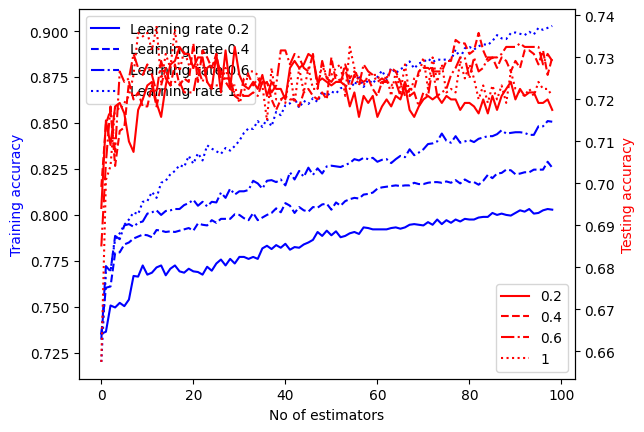

In [15]:
get_accuracy_bag(
    X,
    y,
    title="Training and Test Accuracy vs Weak Classifiers",
    Learning_rate_=[0.2,0.4,0.6,1],
    times=20,
    xlabel='Number Estimators'
    )

## Adaboost with different base classifiers

With Adaboost we can also switch out the base classifier. Instead of the DecisionTree, we will use and SVC

In [20]:
base_estimator = SVC(kernel='rbf',gamma=1)
n_estimators = 5
# Algorithm was removed: https://github.com/scikit-learn/scikit-learn/issues/26784
#algorithm = "SAMME"
learning_rate = 1

model = AdaBoostClassifier(
    n_estimators = n_estimators, 
    estimator = base_estimator, 
    learning_rate = learning_rate
    )

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(get_accuracy(X_train, X_test, y_train, y_test, model))

{'test Accuracy': 0.7666666666666667, 'train Accuracy': 0.6857142857142857}


## Cancer dataset boosting

We'll use this dataset to illustrate using gridsearch together with adaboost toi find an optimal model

In [22]:
from sklearn.model_selection import GridSearchCV

df = pd.read_csv("./data/cell_samples.csv")
df= df[pd.to_numeric(df['BareNuc'], errors='coerce').notnull()]

features = ['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']
target = 'Class'

X = df[features].values
y = df[target]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

model = AdaBoostClassifier()
model.get_params().keys()

dict_keys(['algorithm', 'estimator', 'learning_rate', 'n_estimators', 'random_state'])

In [23]:
param_grid = {
    'learning_rate': [0.1*(n+1) for n in range(10)],
    'n_estimators' : [2*n+1 for n in range(10)],
    # 'algorithm':['SAMME', 'SAMME.R'] => deprecated: https://github.com/scikit-learn/scikit-learn/issues/26784
}     

search = GridSearchCV(estimator=model, param_grid=param_grid,scoring='accuracy')
search.fit(X_train, y_train)

search.best_score_, search.best_params_

(np.float64(0.9670725604670558), {'learning_rate': 0.1, 'n_estimators': 7})

In [24]:
print(get_accuracy(X_train, X_test, y_train, y_test, search.best_estimator_))

{'test Accuracy': 0.9562043795620438, 'train Accuracy': 0.9633699633699634}


From this we can see that gridsearch can give a model with decent performance of ~95% on the test data.

## Boosting drugs

The goal is to build a model to find out which drug is appropriate for future patients with the same illness. We'll use labelencoded features and a multiclass output.

In [30]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("./data/drug200.csv")

features = ['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']
target = 'Drug'

X = df[features]
y = df[target]

le_sex = LabelEncoder()
X.loc[:, 'Sex'] = le_sex.fit_transform(X['Sex'])

le_BP = LabelEncoder()
X.loc[:, 'BP'] = le_BP.fit_transform(X['BP'])

le_Chol = LabelEncoder()
X.loc[:, 'Cholesterol'] = le_Chol.fit_transform(X['Cholesterol'])

X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=4)

param_grid = {
    'learning_rate': [0.1*(n+1) for n in range(10)],
    'n_estimators' : [2*n+1 for n in range(10)]
    }

model = AdaBoostClassifier()

search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3
)

search.fit(X_train, y_train)

search.best_score_, search.best_params_

(np.float64(0.8625669694852084), {'learning_rate': 0.9, 'n_estimators': 7})

In [31]:
print(get_accuracy(X_train, X_test, y_train, y_test, search.best_estimator_))

{'test Accuracy': 0.775, 'train Accuracy': 0.85}
